In [182]:
from astropy.io import fits
import numpy as np
from astropy import units
import matplotlib.pyplot as plt
from tqdm import tqdm
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import LombScargle
from lightkurve.lightcurve import LightCurve
from astropy.coordinates import SkyCoord
from matplotlib.gridspec import GridSpec
from scipy.signal import medfilt

parula = np.load('/Users/belugawhale/parula_colors.npy')

rc = Table.read('../rcParams.txt', format='csv')
for name, val in zip(rc['name'], rc['value']):
    plt.rcParams[name] = val
plt.rcParams['font.size'] = 16

In [5]:
first = np.load('../data/stacked_3I_2-3.npy', allow_pickle=True).item()
second= np.load('../data/stacked_3I_1-2.npy', allow_pickle=True).item()

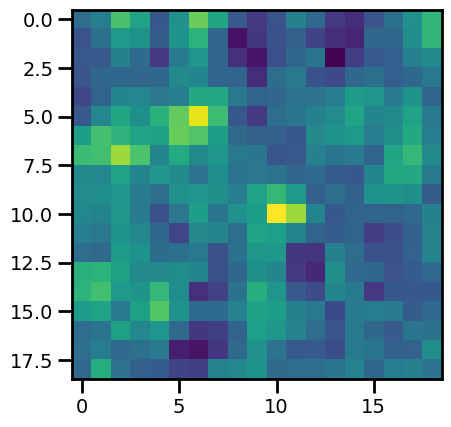

In [6]:
plt.imshow(np.nansum(second['subtracted'][second['good_frames']==1], axis=0))

In [7]:
def convert_mag(counts):
    dur = (len(counts) * 200 * units.s)
    dur = dur.value
    return -2.5 * np.log10(counts/200) + 20.44

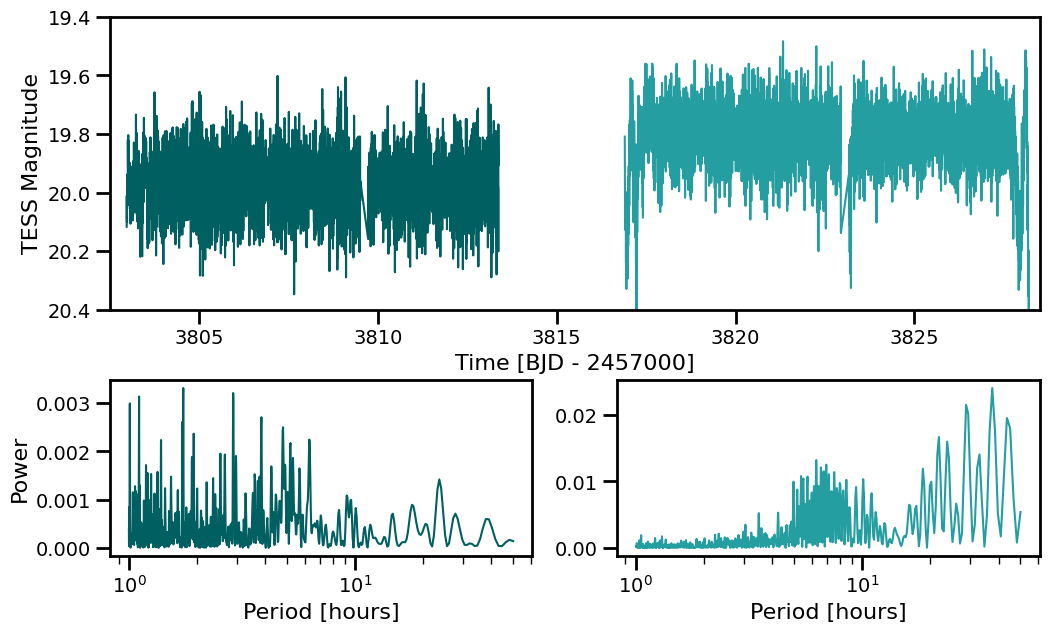

In [10]:
fig = plt.figure(figsize=(12,7))

gs = GridSpec(2, 2, figure=fig, height_ratios=[1,0.6])
ax1 = fig.add_subplot(gs[0,:])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

axes = [ax2, ax3]
colors = ['#005f60', '#249ea0']

total_time = np.array([])
total_lc = np.array([])

for i, ccd in enumerate([first, second]):
    lc = ccd['subtracted'][:,10,10] * np.nanmedian(convert_mag(ccd['raw'][:,10,10]))
    time = ccd['time'] + 2400000.5 - 2457000
    
    if i == 1:
        q = (time > 3816.9) & (time < 3828.2)
    else:
        q = time > 3800
    
    ax1.plot(time[q], lc[q], color=colors[i])

    frequency, power = LombScargle(time[q]*units.day, lc[q]).autopower(minimum_frequency=1.0/(50.0*units.hour),
                                                                       maximum_frequency=1.0/(1.0*units.hour))
    axes[i].plot(1.0/frequency, power, color=colors[i])
    axes[i].set_xscale('log')
    axes[i].set_xlabel('Period [hours]', fontsize=16)


ax1.set_xlabel('Time [BJD - 2457000]', fontsize=16)

ax1.set_ylabel('TESS Magnitude', fontsize=16)
ax1.set_ylim(20.4, 19.4)
ax1.set_xlim(3802.5, 3828.5)

ax2.set_ylabel('Power', fontsize=16)


plt.subplots_adjust(hspace=0.3)

#plt.savefig('tess_lightcurve.pdf', dpi=300, bbox_inches='tight')

In [31]:
lc1 = first['subtracted'][:,10,10] * np.nanmedian(convert_mag(first['raw'][:,10,10]))
time1 = first['time'] + 2400000.5 - 2457000
chunks1 = np.append(np.arange(time1[0], time1[-1], 4), time1[-1])

lc2 = second['subtracted'][:,10,10] * np.nanmedian(convert_mag(second['raw'][:,10,10]))
time2 = second['time'] + 2400000.5 - 2457000

chunks2 = np.append(np.arange(time2[0], time2[-1], 4))#, time2[-1])

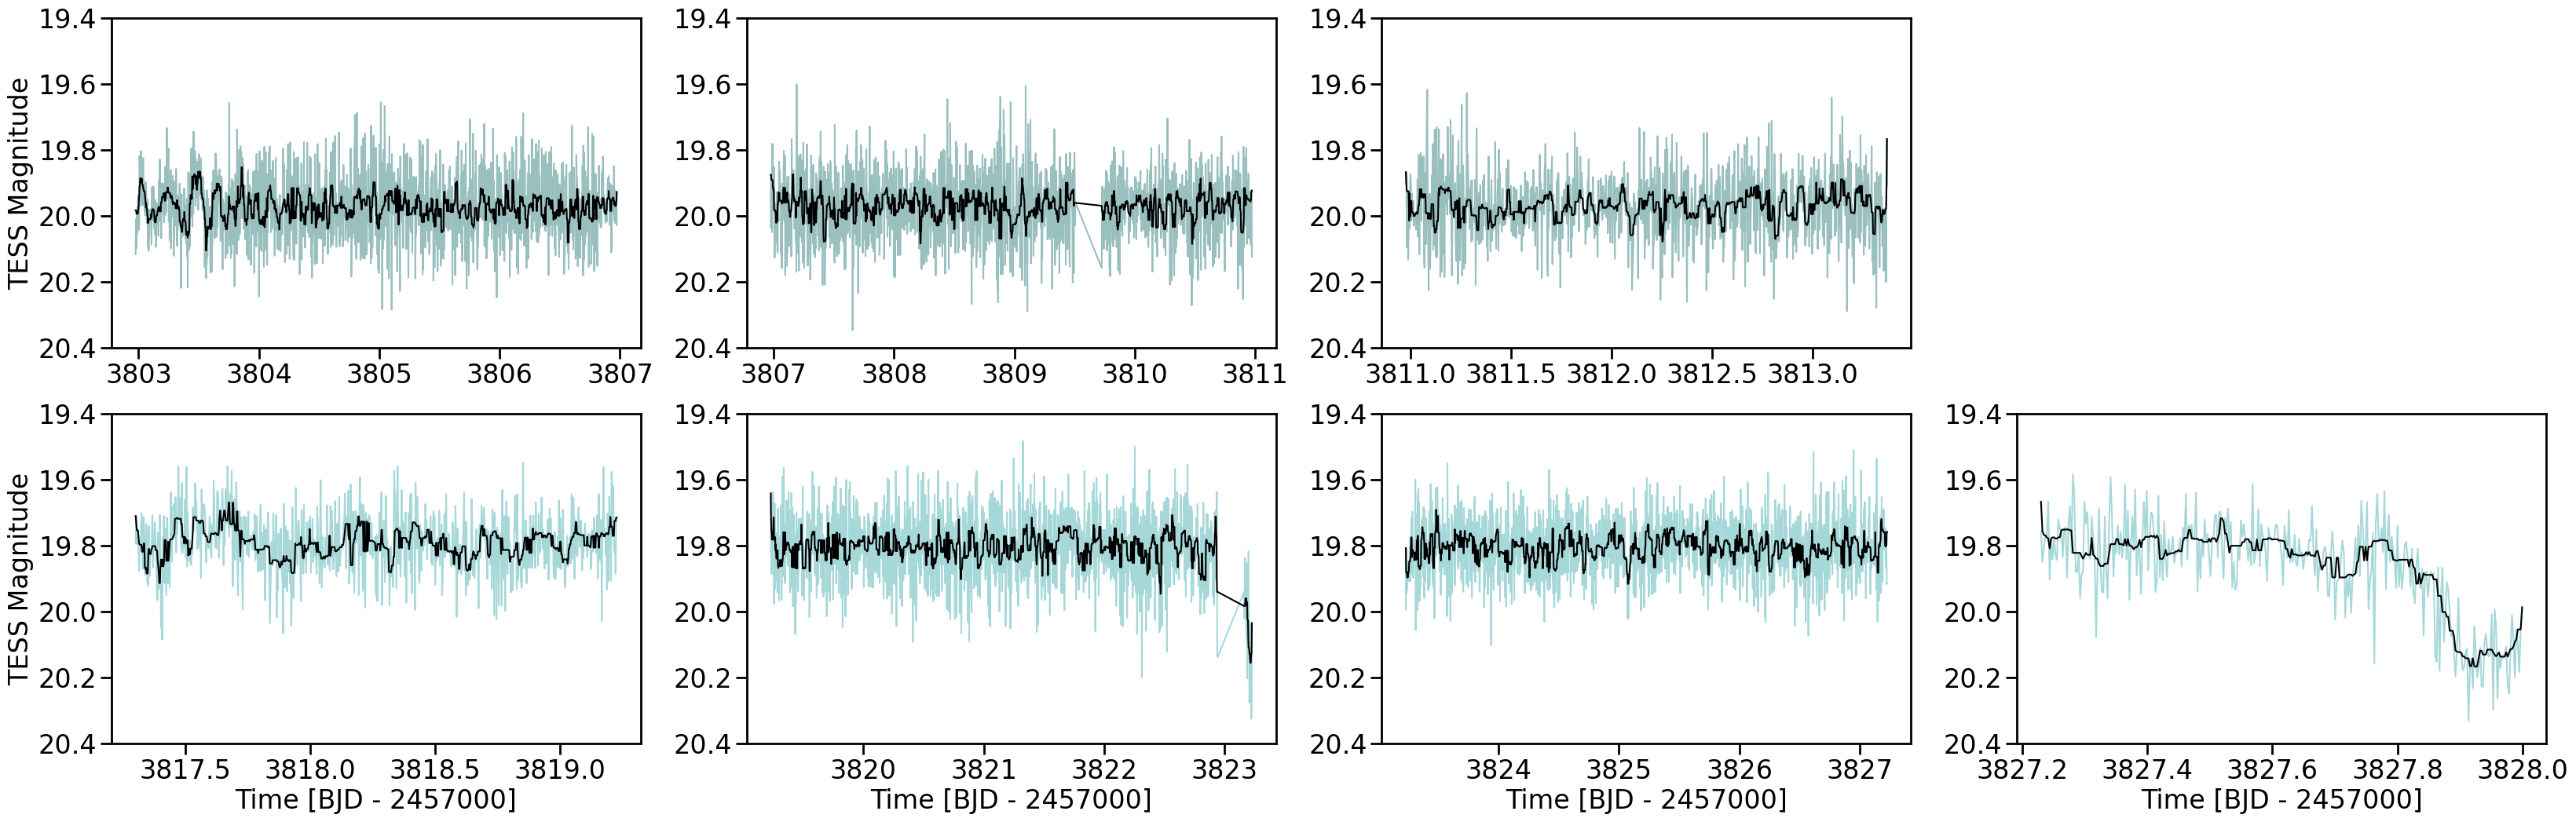

In [144]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,12))
axes = axes.reshape(-1)
fig.set_facecolor('w')

for i in range(len(chunks1)-1):
    q = (time1 >= chunks1[i]) & (time1 < chunks1[i+1])
    axes[i].plot(time1[q], lc1[q], color='#005f60', alpha=0.4)

    m = medfilt(lc1[q], 11)
    axes[i].plot(time1[q], m, color='k')


for i in range(len(chunks2)-1):
    q = (time2 >= chunks2[i]) & (time2 < chunks2[i+1]) & (time2 > 3817.3) & (time2 < 3828)
    axes[i+4].plot(time2[q], lc2[q], color='#249ea0', alpha=0.4)

    m = medfilt(lc2[q], 11)
    axes[i+4].plot(time2[q], m, color='k')

axes[3].set_axis_off()

axes[0].set_ylabel('TESS Magnitude')
axes[4].set_ylabel('TESS Magnitude')

for i in range(4,8):
    axes[i].set_xlabel('Time [BJD - 2457000]')

for i in range(len(axes)):
    axes[i].set_ylim(20.4, 19.4)
    axes[i].set_rasterized(True)

plt.savefig('../figures/broken_lc.png', bbox_inches='tight', dpi=350)

## Background light curve

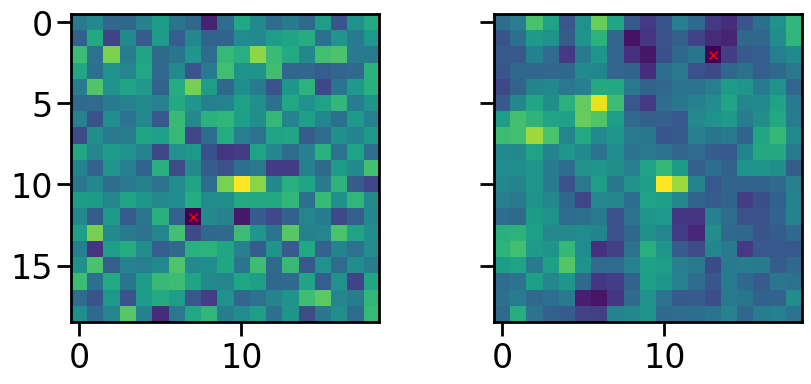

In [130]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)

ax1.imshow(np.nansum(first['subtracted'], axis=0))
ax1.plot(7, 12,'rx')

ax2.imshow(np.nansum(second['subtracted'][second['good_frames']==1], axis=0))
ax2.plot(13,2,'rx')

In [135]:
bkg1 = first['subtracted'][:,7,12] * np.nanmedian(convert_mag(first['raw'][:,7,12]))

bkg2 = second['subtracted'][:,13,2] * np.nanmedian(convert_mag(second['raw'][:,13,2]))

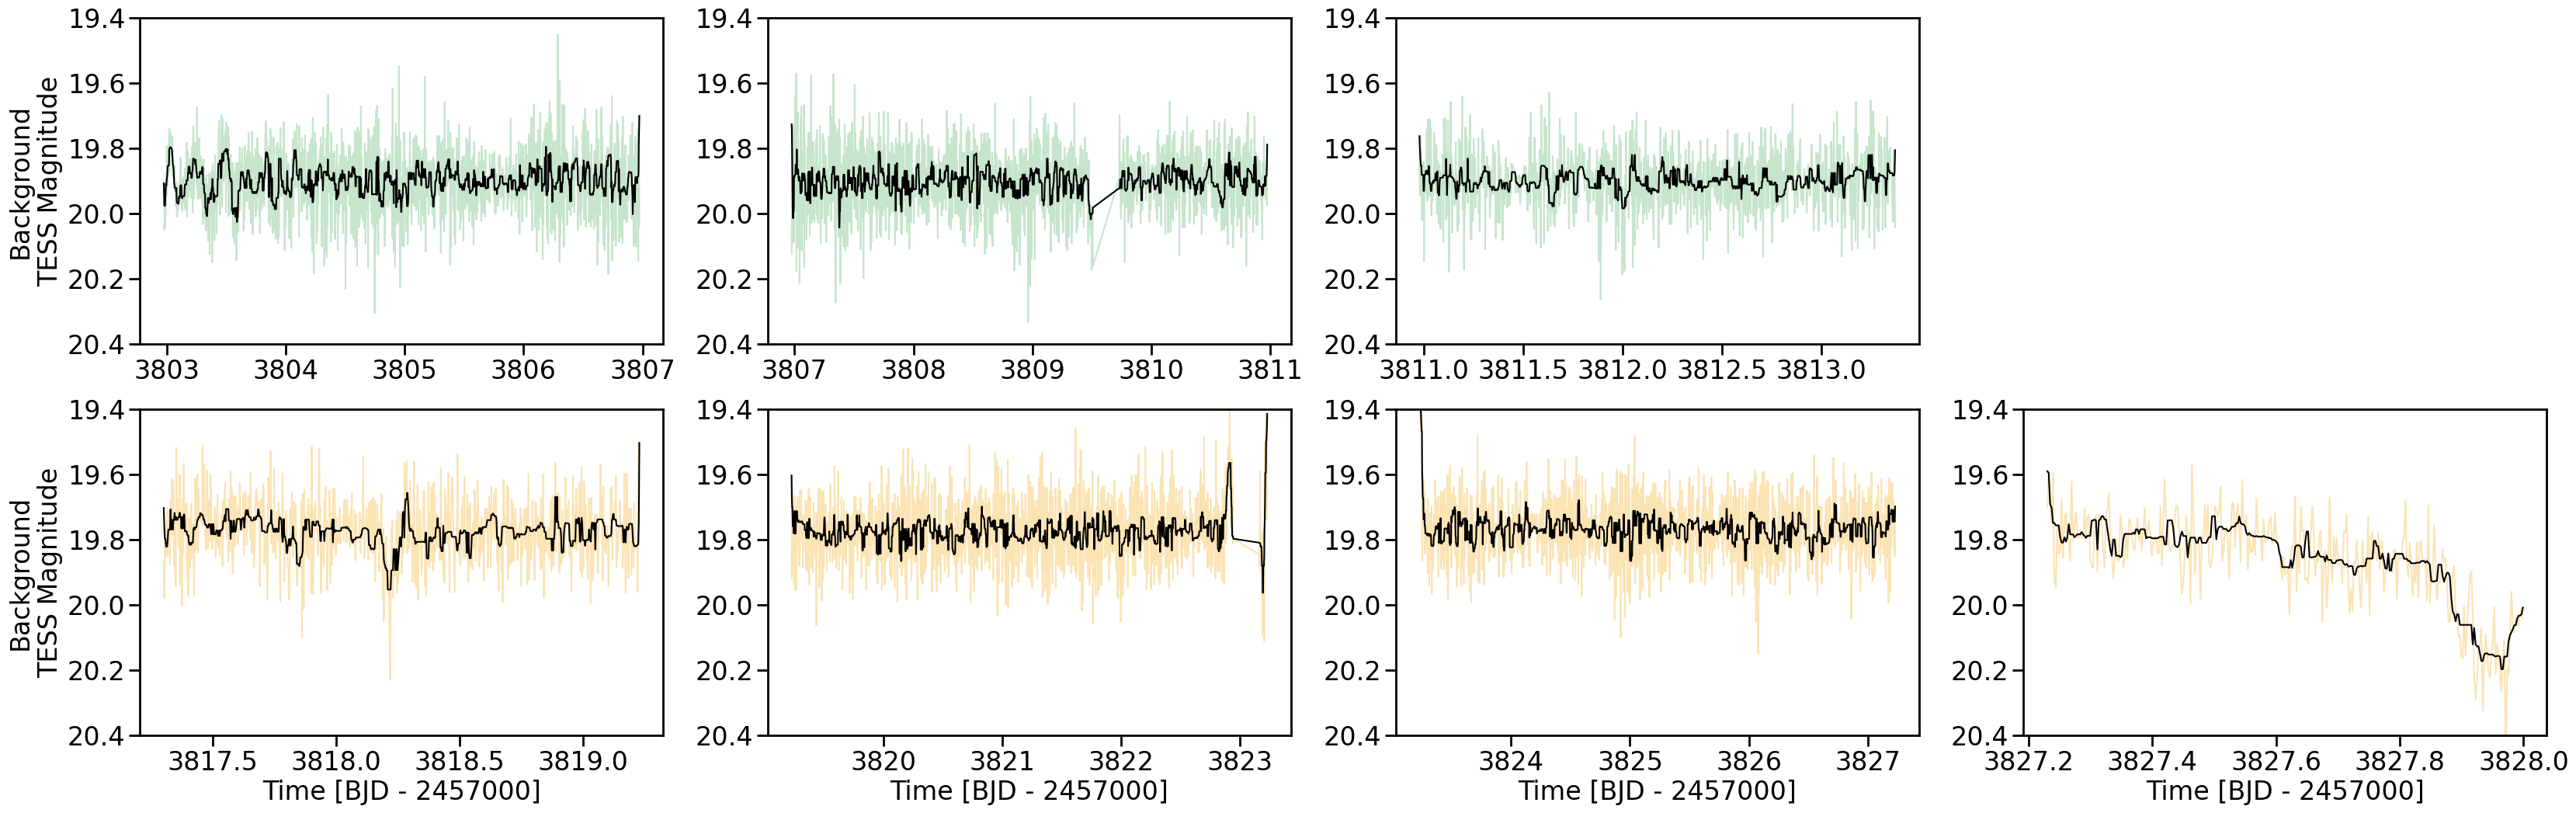

In [143]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40,12))
axes = axes.reshape(-1)
fig.set_facecolor('w')

for i in range(len(chunks1)-1):
    q = (time1 >= chunks1[i]) & (time1 < chunks1[i+1])
    axes[i].plot(time1[q], bkg1[q], color=parula[150], alpha=0.4)

    m = medfilt(bkg1[q], 11)
    axes[i].plot(time1[q], m, color='k')


for i in range(len(chunks2)-1):
    q = (time2 >= chunks2[i]) & (time2 < chunks2[i+1]) & (time2 > 3817.3) & (time2 < 3828)
    axes[i+4].plot(time2[q], bkg2[q], color=parula[210], alpha=0.4)

    m = medfilt(bkg2[q], 11)
    axes[i+4].plot(time2[q], m, color='k')

axes[3].set_axis_off()

axes[0].set_ylabel('Background\nTESS Magnitude')
axes[4].set_ylabel('Background\nTESS Magnitude')

for i in range(4,8):
    axes[i].set_xlabel('Time [BJD - 2457000]')

for i in range(len(axes)):
    axes[i].set_ylim(20.4, 19.4)
    axes[i].set_rasterized(True)

plt.savefig('../figures/broken_background_lc.png', bbox_inches='tight', dpi=350)

## Periodograms

In [180]:
def periodogram(t, f, maxp=1*units.hour, minp=3*units.day):
    med = medfilt(f, 11)
    ls = LombScargle(t*units.day, med).autopower(minimum_frequency=1.0/minp.to(units.day), 
                                                 maximum_frequency=1.0/maxp.to(units.day))
    return ls, med

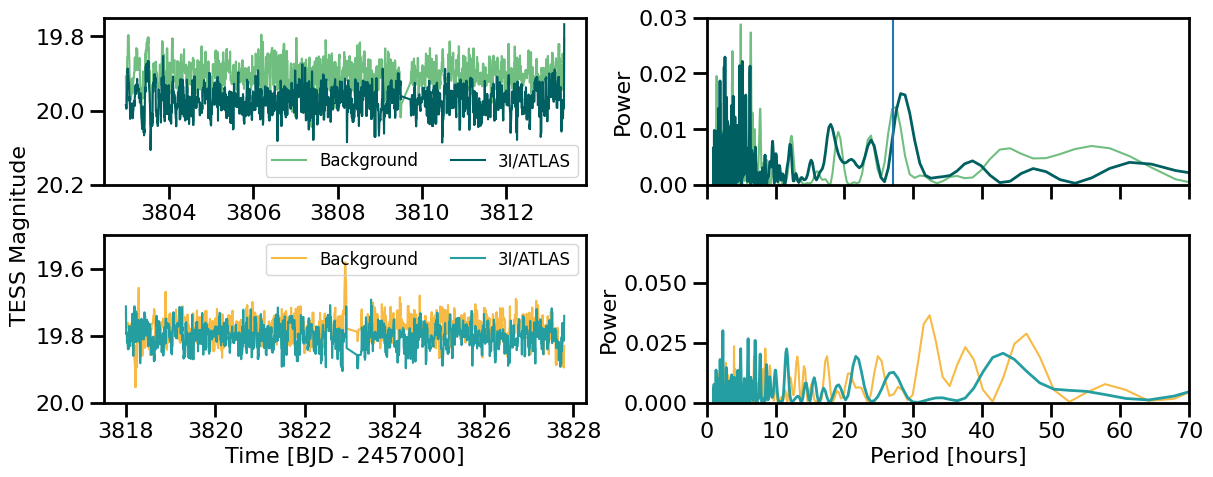

In [256]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(14,5))
fig.set_facecolor('w')
axes = axes.reshape(-1)



bkg_23, bk23 = periodogram(time1, bkg1)
axes[1].plot((1.0/bkg_23[0]).to(units.hour), bkg_23[1], color=parula[150])

ls_23, m23 = periodogram(time1, lc1)
axes[1].plot((1.0/ls_23[0]).to(units.hour), ls_23[1], color='#005f60', lw=2)


axes[0].plot(time1, bk23,color=parula[150], label='Background')
axes[0].plot(time1, m23, color='#005f60', label='3I/ATLAS')
axes[0].legend(fontsize=12, ncol=2)

q = (time2 >= 3818) & (time2 < 3827.8) & (lc2 < 20.) & (bkg2 > 19.5)



bkg_12, mb12 = periodogram(time2[q], bkg2[q])
axes[3].plot((1.0/bkg_12[0]).to(units.hour), bkg_12[1], color=parula[210])

ls_12, m12 = periodogram(time2[q], lc2[q])
axes[3].plot((1.0/ls_12[0]).to(units.hour), ls_12[1], color='#249ea0', lw=2)


axes[2].plot(time2[q], mb12, color=parula[210], label='Background')
axes[2].plot(time2[q], m12, color='#249ea0', label='3I/ATLAS')
axes[2].legend(fontsize=12, ncol=2)

axes[3].set_xlabel('Period [hours]')
for i in [1,3]:
    axes[i].set_xlim(0,70)
    axes[i].set_ylabel('Power')
axes[3].set_ylim(0,0.07)
axes[1].set_ylim(0,0.03)
axes[1].set_xticklabels([])

axes[0].set_ylim(20.2, 19.75)
axes[2].set_ylim(20., 19.5)

axes[2].set_xlabel('Time [BJD - 2457000]')
axes[2].set_ylabel('TESS Magnitude', y=1)

axes[1].axvline(27)

for i in range(4):
    axes[i].set_rasterized(True)

plt.subplots_adjust(hspace=0.3, wspace=0.25)
#plt.savefig('../figures/ls_comparison.png', dpi=300, bbox_inches='tight')

In [260]:
np.nanmedian(lc2[q]), np.nanstd(lc2[q])

(19.801371885182654, 0.08300184944577145)

## Write to a table

In [139]:
tab = Table()

q = (time2 > 3816.9) & (time2 < 3828.2)

tab['time_tbjd'] = np.append(time1, time2[q])
tab['mag'] = np.append(lc1, lc2[q])

tab.write('../data/tess_lightcurve.csv', format='csv')

In [145]:
tab = Table()

q = (time2 > 3816.9) & (time2 < 3828.2)

tab['time_tbjd'] = np.append(time1, time2[q])
tab['mag'] = np.append(bkg1, bkg2[q])

tab.write('../data/tess_bkg_lightcurve.csv', format='csv')

## Significance of the pixel

In [261]:
tpf1 = np.nansum(first['subtracted'], axis=0)
tpf2 = np.nansum(second['subtracted'][second['good_frames']==1], axis=0)

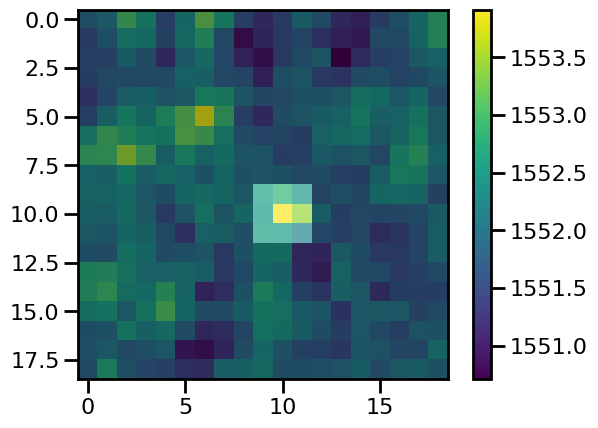

In [318]:
mask = np.ones(tpf2.shape, dtype=bool)
mask[9:12, 9:12] = False
plt.imshow(tpf2)#, vmin=1535, vmax=1555)
plt.colorbar()
plt.imshow(mask, alpha=0.3, cmap='Greys')

In [322]:
z = tpf1*mask > 0
med = np.nanmedian(tpf1[z]*mask[z])
sig = np.nanstd(tpf1[z]*mask[z])

print(med, sig)

4398.9823180929725 0.2900673628708912


In [298]:
(tpf1[10,10] - med)/sig

3.7143349330979154

In [323]:
z = tpf2*mask > 0
med = np.nanmedian(tpf2[z]*mask[z])
sig = np.nanstd(tpf2[z]*mask[z])

(tpf2[10,10]-med)/sig

4.155865798604809

In [324]:
med, sig

(1551.98019460072, 0.46541679106195927)